<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/ML/report_AM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
! pip install sklearn_extensions
from sklearn.neural_network import MLPRegressor
from sklearn_extensions.extreme_learning_machines.elm import ELMRegressor
from sklearn_extensions.extreme_learning_machines.random_layer import RBFRandomLayer, MLPRandomLayer
from sklearn.metrics import mean_squared_error as MSE

In [0]:
import statsmodels.api as sm

In [0]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6

In [9]:
dados = pd.read_csv('monthly-sunspots.csv')
dados = dados['Sunspots']
dados.head()

0    58.0
1    62.6
2    70.0
3    55.7
4    85.0
Name: Sunspots, dtype: float64

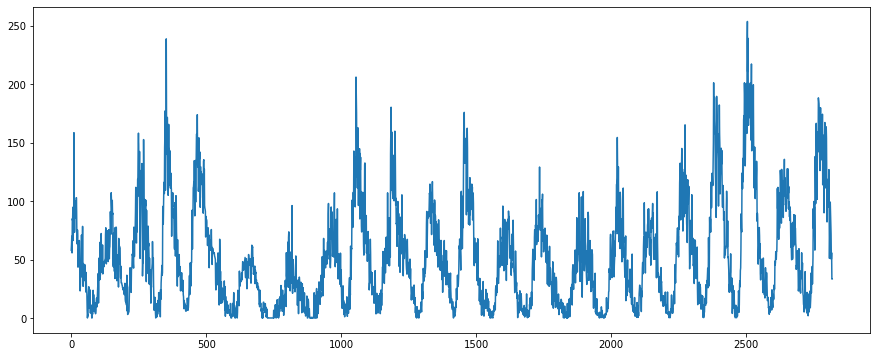

In [10]:
plt.plot(dados)
plt.show()

In [0]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y

In [0]:
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(serie)

In [0]:
serie = dados.values
serie_normalizada = normalizar_serie(serie)

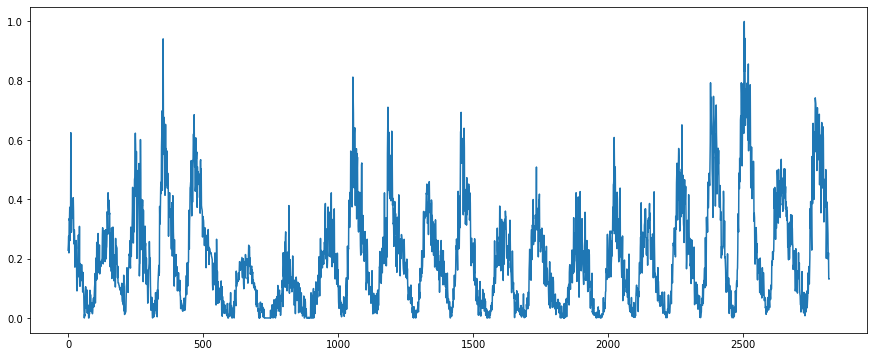

In [14]:
plt.plot(serie_normalizada)
plt.show()

In [0]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

In [16]:
qtd_lags = 5
janelas = gerar_janelas(5, serie_normalizada)
janelas[0]

array([0.2285264 , 0.24665091, 0.27580772, 0.21946414, 0.33490938,
       0.32899921])

In [17]:
janelas.shape

(2814, 6)

In [0]:
def diferenciar_serie(serie):
    #serie: obj pandas
    return serie.diff().dropna()

In [0]:
def incrementar_serie(serie_real, serie_diff):
    return serie_real[0:-1] + serie_diff

In [0]:
serie_diff = diferenciar_serie(dados)

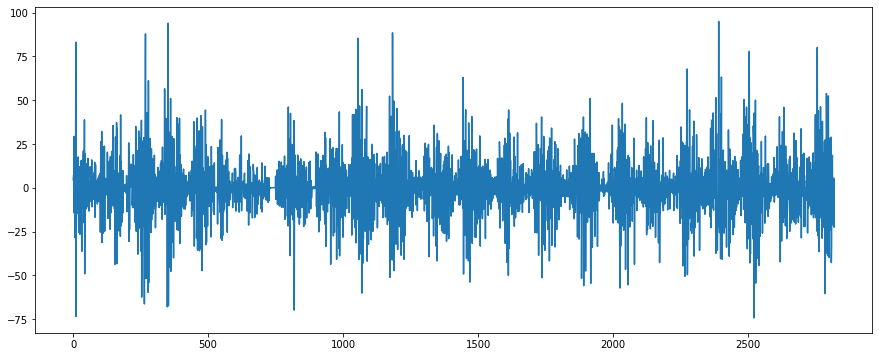

In [21]:
plt.plot(serie_diff)
plt.show()

In [0]:
serie_rt = incrementar_serie(dados.values, serie_diff.values)

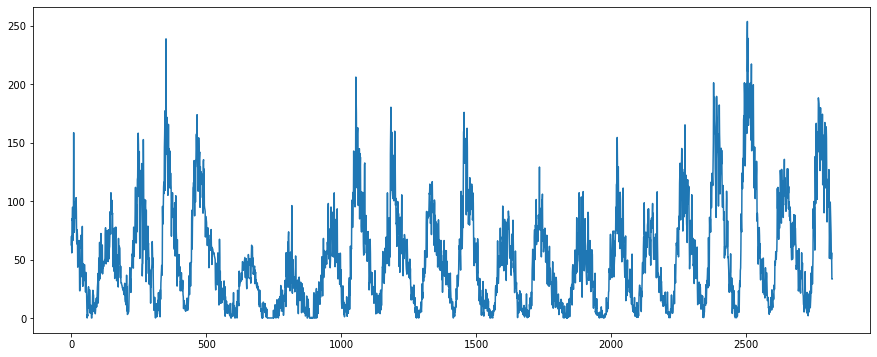

In [23]:
plt.plot(serie_rt)
plt.show()

In [0]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]
    
    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)
       
    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x
    
    lags_selecionados = []
    
    for i in range(1, max_lag+1):

        
        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0
    
    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

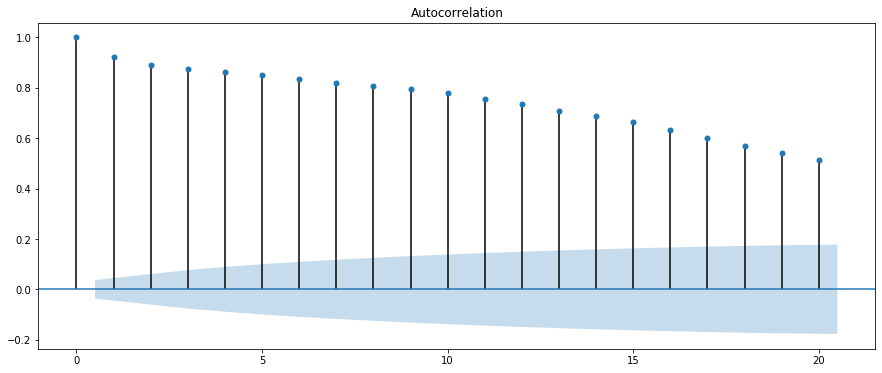

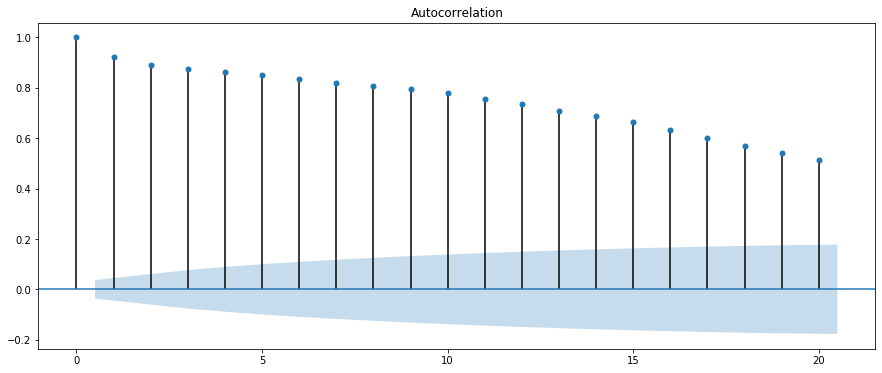

In [25]:
sm.graphics.tsa.plot_acf(serie_normalizada, lags=20)

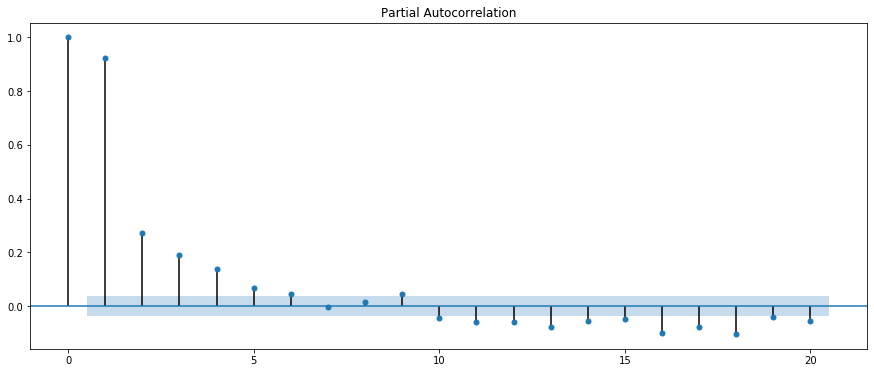

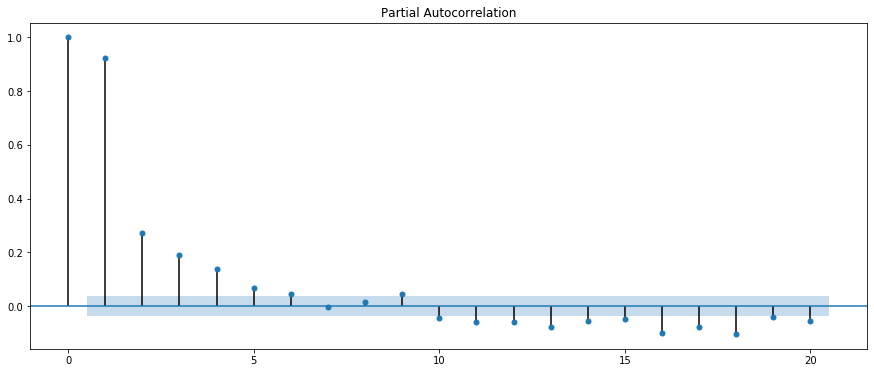

In [26]:
sm.graphics.tsa.plot_pacf(serie_normalizada, lags=20)

In [27]:
lag_sel = select_lag_acf(serie_normalizada, 20)

LAGS [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [28]:
lag_sel

[19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

## Split serie with lags

In [0]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [0]:
tam_janela = 20
serie_janelas = gerar_janelas(tam_janela, serie_normalizada)

In [31]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(serie_janelas, 0.50, perc_val = 0.25)

Particao de Treinamento: 0 1399
Particao de Validacao: 1399 2098
Particao de Teste: 2098 2799


## MLP train

In [0]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec):
    
    # Grid
    neuronios =  [10, 50, 80, 100]
    func_activation = ['tanh', 'relu']
    alg_treinamento = ['lbfgs', 'adam']
    max_iteracoes = [10000]
    learning_rate = ['constant', 'adaptive']
    
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):
                        for qtd_lag in range(1, len(x_train[0]+1)): #variar a qtd de pontos utilizados na janela 
                            
                            print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])

                            for e in range(0, num_exec):
                                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation[j], solver=alg_treinamento[l], max_iter = max_iteracoes[m], learning_rate= learning_rate[n])
                                
                                mlp.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                                mse = MSE(y_val, predict_validation)

                                if mse < best_result:
                                    best_result = mse
                                    print('Melhor MSE:', best_result)
                                    select_model = mlp
                                    qtd_lags_sel = qtd_lag
    
    
    return select_model, qtd_lags_sel

In [33]:
modelo_mlp, lag_sel_mlp = treinar_mlp(x_train, y_train, x_val, y_val, 5)

QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.0036680176993269475
Melhor MSE: 0.0036544469245018496
Melhor MSE: 0.0036489228308023004
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.003434950919466891
Melhor MSE: 0.003411823412871703
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.003291616266795957
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.0032258403243182313
Melhor MSE: 0.003216076826498023
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.00320711299953195
Melhor MSE: 0.003200543847775604
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.0031897335123640394
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuroni

# ELM Train

In [0]:
def treinar_elm(x_train, y_train, x_val, y_val, num_exec):
    
    # Grid
    neuronios =  [10, 50, 80, 100]
    func_activation = [
      'tanh', 'tribas', 'hardlim'
    ]
    
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
              for qtd_lag in range(1, len(x_train[0]+1)): #variar a qtd de pontos utilizados na janela 
                            
                    print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])

                    for e in range(0, num_exec):
                        elm = ELMRegressor(
                                n_hidden=neuronios[i], 
                                activation_func=func_activation[j]
                            )
                                
                        elm.fit(x_train[:,-qtd_lag:], y_train)
                        predict_validation = elm.predict(x_val[:,-qtd_lag:])
                        mse = MSE(y_val, predict_validation)

                        if mse < best_result:
                            best_result = mse
                            print('Melhor MSE:', best_result)
                            select_model = elm
                            qtd_lags_sel = qtd_lag
    
    
    return select_model, qtd_lags_sel

In [42]:
modelo_elm, lag_sel_elm = treinar_elm(x_train, y_train, x_val, y_val, 5)

QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.0036498637047232716
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.003530385904804125
Melhor MSE: 0.00350704654616142
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.0034101121170015576
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.0033387558116728102
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neu

## Experiments

In [43]:
from sklearn.base import clone

mse_mlp = []
mse_elm = []

for e in range(0, 30):
  # MLP
  mlp = clone(modelo_mlp)
                                
  mlp.fit(x_train[:,-lag_sel_mlp:], y_train)
  predict_validation = mlp.predict(x_val[:,-lag_sel_mlp:])
  mse = MSE(y_val, predict_validation)
  
  mse_mlp.append(mse)
  
  # ELM
  elm = clone(modelo_elm)
                                
  elm.fit(x_train[:,-lag_sel_elm:], y_train)
  predict_validation = elm.predict(x_val[:,-lag_sel_elm:])
  mse = MSE(y_val, predict_validation)
  
  mse_elm.append(mse)
  
print(mse_mlp)
print(mse_elm)

[0.0031900257670113047, 0.0032642347375089462, 0.0031496922339690004, 0.0032116856880033975, 0.003190535291472041, 0.003242590138816875, 0.0032174912523910753, 0.0032299818668604097, 0.003171526274728919, 0.0031859790179594627, 0.0033505464811727195, 0.0032132228423206784, 0.0031789413813719147, 0.0031674849782331715, 0.0032019353349735176, 0.0031895952910733277, 0.003250256172245004, 0.0032363659780931925, 0.0031515568325455588, 0.003202067351598143, 0.003174619124100516, 0.0031844112704576435, 0.003196168940314371, 0.003193479594889233, 0.0032160454296229326, 0.0032539244597906735, 0.003170101901887641, 0.00313925501140099, 0.003190036275840386, 0.003262537638312368]
[0.0032699314056695173, 0.0033591299411059065, 0.0034191264903494774, 0.0038310967066843503, 0.0035112213169124482, 0.003319167873812863, 0.0033566788644750177, 0.0036160197323176334, 0.0033962674483830127, 0.0035704276008167186, 0.003539800826347888, 0.0037307083829219026, 0.003482773637479753, 0.003690012271491601, 0.0

In [44]:
print('MLP\t mean=%f, std=%f, min=%f' % (np.mean(mse_mlp), np.std(mse_mlp), np.min(mse_mlp)))
print('ELM\t mean=%f, std=%f, min=%f' % (np.mean(mse_elm), np.std(mse_elm), np.min(mse_elm)))

MLP	 mean=0.003206, std=0.000042, min=0.003139
ELM	 mean=0.003544, std=0.000372, min=0.003270


## teste

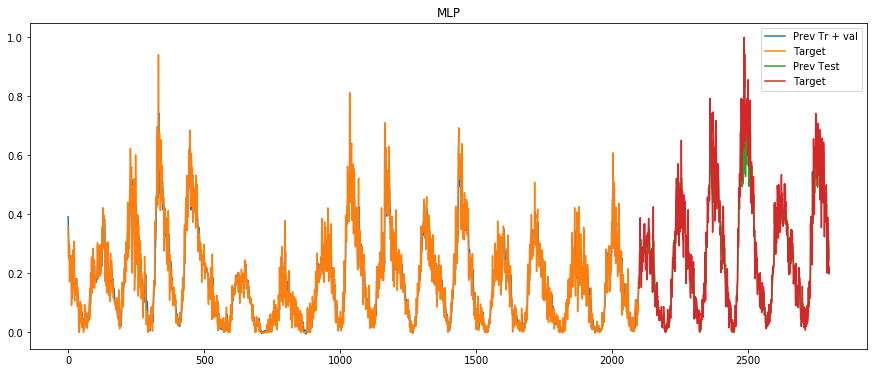

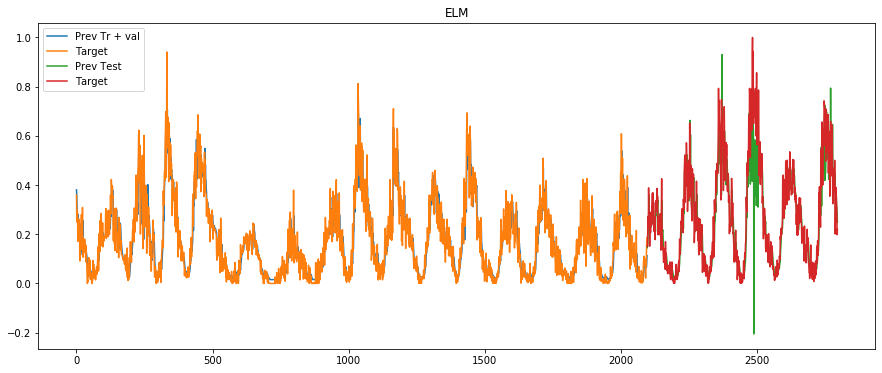

In [45]:
for name, modelo, lag_sel in [('MLP', modelo_mlp, lag_sel_mlp), ('ELM', modelo_elm, lag_sel_elm)]:

  predict_train = modelo.predict(x_train[:, -lag_sel:])
  predict_val = modelo.predict(x_val[:, -lag_sel:])
  predict_test = modelo.predict(x_test[:, -lag_sel:])

  previsoes_train = np.hstack(( predict_train, predict_val))
  target_train = np.hstack((y_train, y_val))
  
  p_index = [i for i in range(len(predict_train)+len(predict_val), 
                              len(predict_train)+len(predict_val)+len(predict_test))]
  
  plt.plot(previsoes_train, label = 'Prev Tr + val')
  plt.plot(target_train, label='Target')
  plt.legend(loc='best')
  # plt.show()
  
  plt.plot(p_index, predict_test, label = 'Prev Test')
  plt.plot(p_index, y_test, label='Target')
  plt.legend(loc='best')
  plt.title(name)
  plt.show()